# Question 2: Identify Areas Most Affected by the Top Complaint Type

The goal of this exercise is to explore the data further and find the answer to the second question of the problem statement:

*Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?*

<br>

# Introduction

Again, we start by importing the necessary libraries and loading the 311 Dataset onto a DataFrame.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'retina'

C:\Users\ko40\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [2]:
columns = ['Created Date', 'Unique Key', 'Complaint Type', 'Incident Zip', 'Incident Address', 'Street Name',
           'Address Type', 'City', 'Resolution Description', 'Borough', 'Latitude', 'Longitude', 'Closed Date', 
           'Location Type', 'Status']

df = pd.read_csv('311_Service_Requests_from_2010_to_Present_min.csv', 
                 nrows = 1E+7, 
                 usecols = columns, 
                 parse_dates = ['Created Date', 'Closed Date'])

df_raw = df.copy()
df.head()

,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Street Name,Address Type,City,Status,Resolution Description,Borough,Latitude,Longitude
0,45531130,2020-02-02 06:09:17,NaT,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.0,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,Open,The following complaint conditions are still o...,MANHATTAN,40.765132,-73.988993
1,45529784,2020-02-02 14:15:24,NaT,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.0,1751 67 STREET,67 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.618484,-73.992673
2,45527528,2020-02-02 02:27:41,NaT,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,Open,The following complaint conditions are still o...,QUEENS,40.750269,-73.879432
3,45530329,2020-02-02 12:13:18,NaT,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.853773,-73.881558
4,45528814,2020-02-02 13:59:44,NaT,APPLIANCE,RESIDENTIAL BUILDING,11209.0,223 78 STREET,78 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.629745,-74.030533


We will also import a geojson file for the boundary of each borough.

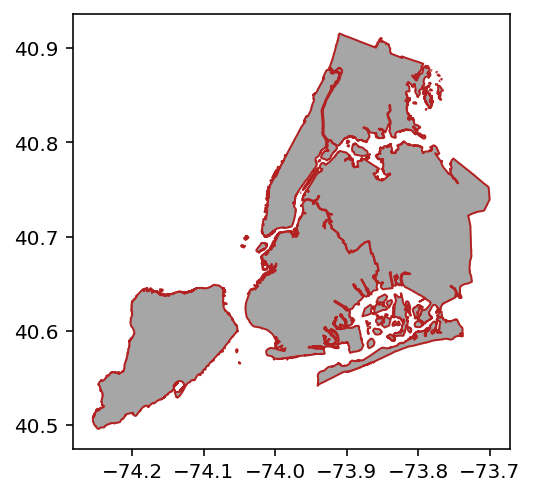

In [3]:
borough_map = gpd.read_file('https://github.com/codeforamerica/click_that_hood/blob/master/public/data/new-york-city-boroughs.geojson?raw=truen')

fig, ax = plt.subplots(figsize = (4, 4)) 

borough_map['geometry'].boundary.plot(edgecolor = 'firebrick', linewidth = 1, ax = ax)
borough_map.plot(color = 'grey', alpha = 0.7, ax = ax);

We should not forget to merge the 'HEATING' and 'HEAT/HOT WATER' complaint types.

In [4]:
df['Complaint Type'] = np.where(df['Complaint Type'] == 'HEATING','HEAT/HOT WATER', df['Complaint Type'])
df['Complaint Type'].value_counts().head()

HEAT/HOT WATER          2149424
PLUMBING                 711130
GENERAL CONSTRUCTION     500863
UNSANITARY CONDITION     451643
PAINT - PLASTER          361257
Name: Complaint Type, dtype: int64

# Data Analysis

In Problem I, we concluded that 'HEAT/HOT WATER' is the most severe type of complaint in New York between 2010 and 2020. For the current problem set, we need to investigate if particular locations are more critical in addressing the issue.

For this purpose, we will make a new dataset containing columns only for 'Borough', 'Incident ZIP', 'Street Name', Latitude', 'Longitude' and 'Complaint Type', and rows corresponding to 'HEAT/HOT WATER'.


In [5]:
df_tc = df[['Borough', 'Incident Zip', 'Street Name', 'Latitude', 'Longitude', 'Complaint Type']]
df_tc = df_tc[df_tc['Complaint Type'] == 'HEAT/HOT WATER']

df_tc.head()

,Borough,Incident Zip,Street Name,Latitude,Longitude,Complaint Type
0,MANHATTAN,10019.0,WEST 52 STREET,40.765132,-73.988993,HEAT/HOT WATER
2,QUEENS,11372.0,37 AVENUE,40.750269,-73.879432,HEAT/HOT WATER
3,BRONX,10458.0,SOUTHERN BOULEVARD,40.853773,-73.881558,HEAT/HOT WATER
5,BRONX,10456.0,MORRIS AVENUE,40.831381,-73.915218,HEAT/HOT WATER
7,QUEENS,11372.0,81 STREET,40.749320,-73.885190,HEAT/HOT WATER


We should check for missing values in our new dataset.

In [6]:
missing_counts = df_tc.isnull().sum().sort_values(ascending = False)
percent = (df_tc.isnull().sum()*100/df_tc.shape[0]).sort_values(ascending = False)

missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
print('Missing values: ')
missing_df.head()

Missing values: 


,Counts,%
Incident Zip,19024,0.885074
Longitude,19020,0.884888
Latitude,19020,0.884888
Street Name,1,0.000047
Complaint Type,0,0.000000


<AxesSubplot:>

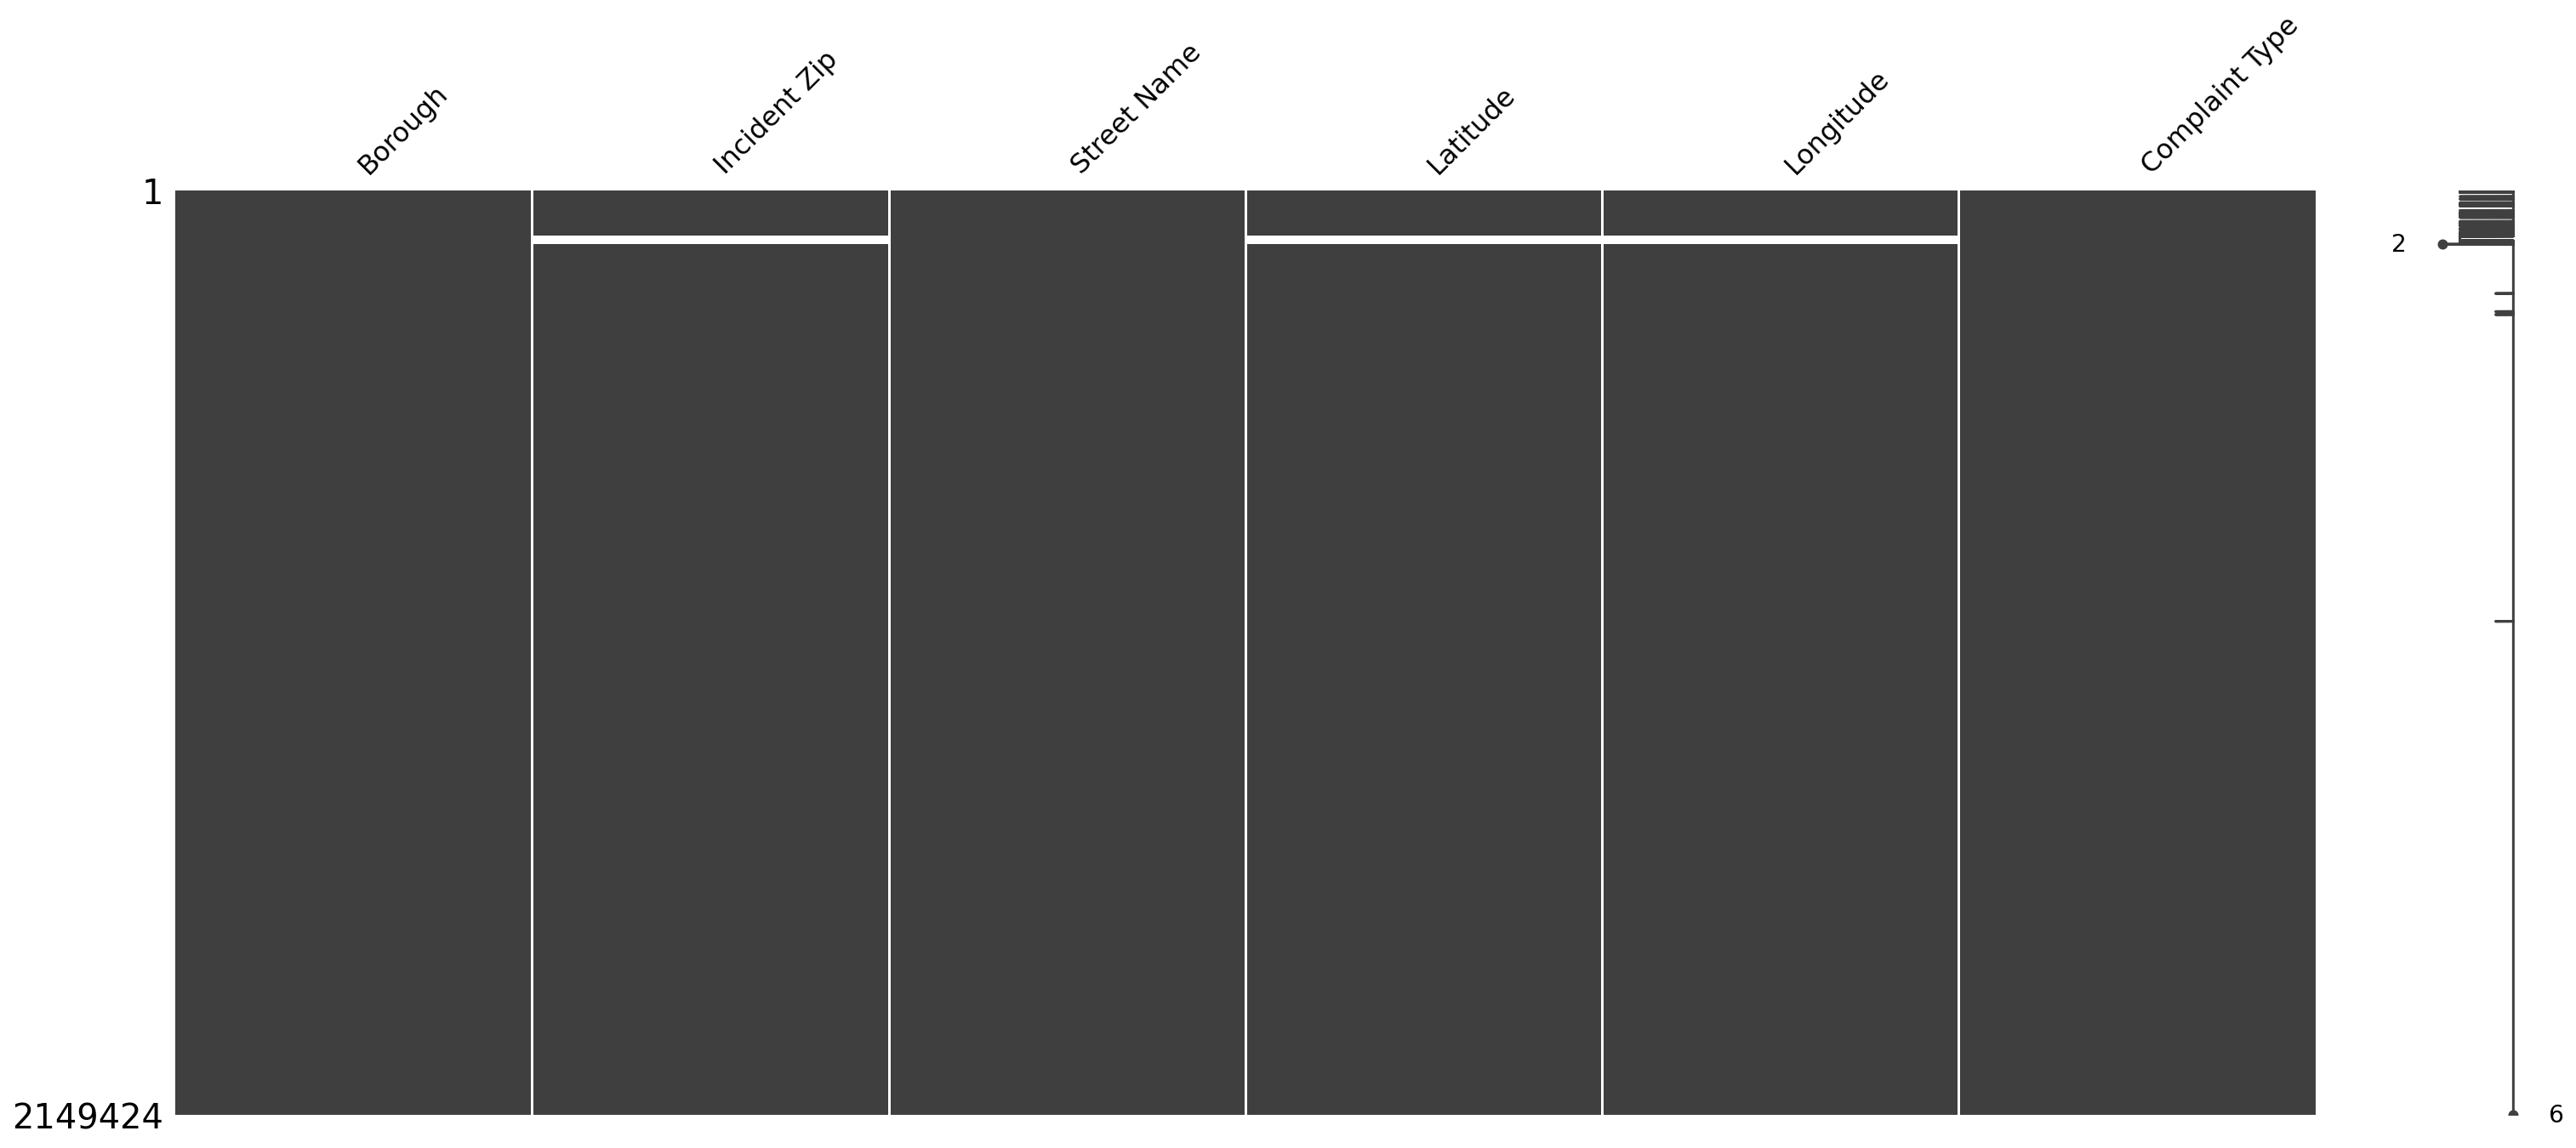

In [7]:
msno.matrix(df_tc)

Three columns contain missing values. Luckily, the number of missing values amounts to only a small portion (~1%) for all these columns.

## Borough

Let’s use the `value_counts()` method to list all boroughs and the total number of ‘HEAT/HOT WATER’ complaints in each. 

In [8]:
df_tc['Borough'].value_counts()

BRONX            606133
BROOKLYN         574845
MANHATTAN        423039
Unspecified      282917
QUEENS           244122
STATEN ISLAND     18368
Name: Borough, dtype: int64

Notice that some instances have an ‘Unspecified’ borough. We can assign the actual borough name since other information (street name, zip code, etc.) are available. However, we can safely ignore those instances for now. 

In [9]:
df_tc = df_tc[df_tc['Borough'] != 'Unspecified']
df_tc['Borough'].value_counts()

BRONX            606133
BROOKLYN         574845
MANHATTAN        423039
QUEENS           244122
STATEN ISLAND     18368
Name: Borough, dtype: int64

We can plot a map to visualise the distribution of 'HEAT/HOT WATER' complaints. 

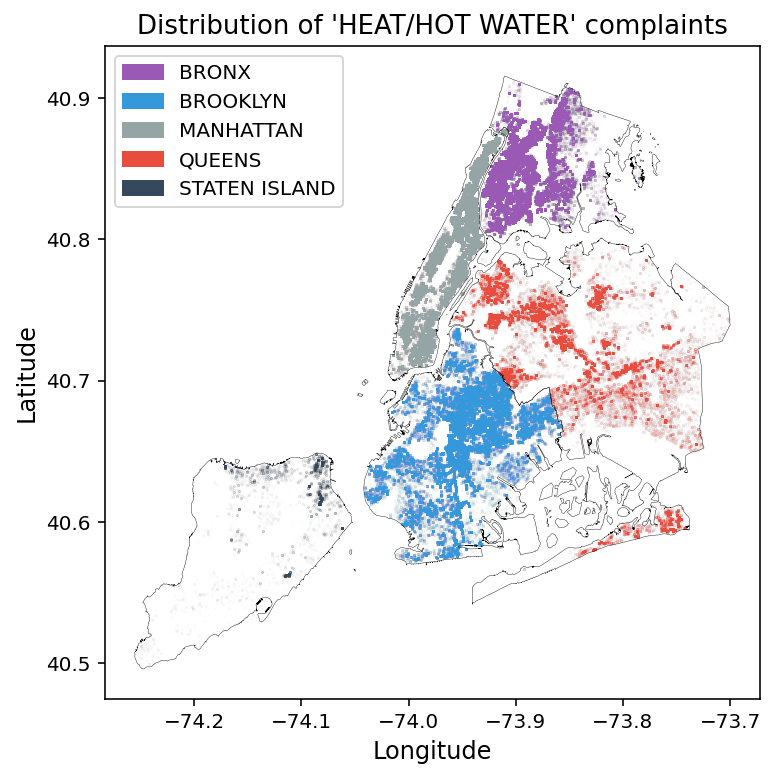

In [10]:
boroughs = list(df_tc['Borough'].value_counts().index)
colors = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
patches = []

fig, ax = plt.subplots(figsize = (6, 6))

for index, value in enumerate(boroughs):
    borough_df = df_tc[df_tc['Borough'] == value]
    ax.scatter(borough_df['Longitude'], borough_df['Latitude'], c = colors[index], s = 0.5, alpha = 0.01, marker = '.')
    patches.append(mpatches.Patch(label = value, color = colors[index]))
 
borough_map['geometry'].boundary.plot(edgecolor = 'black', linewidth = 0.2, ax = ax)

plt.title("Distribution of 'HEAT/HOT WATER' complaints", size = 13)
plt.xlabel('Longitude', size = 12)
plt.ylabel('Latitude', size = 12)
plt.legend(patches, boroughs);

The last scatter plot shows that the boroughs with the highest number of 'HEAT/HOT WATER' complaints are the Bronx, Brooklyn, and Manhattan.

We can quantify this observation with a bar plot:


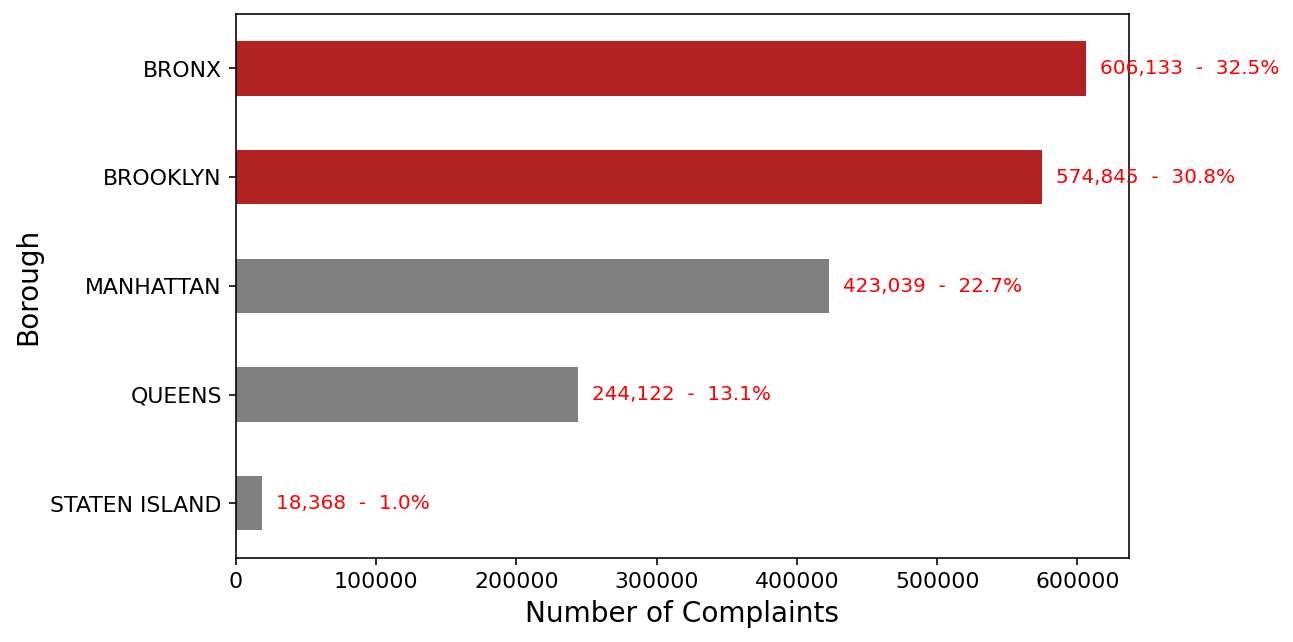

In [11]:
colors = ['Grey', 'Grey', 'Grey', 'Firebrick', 'Firebrick']
ny_borough = df_tc['Borough'].value_counts().sort_values()

ny_borough.plot(kind = 'barh', figsize = (8, 5), fontsize = 11, color = colors)
plt.ylabel('Borough', fontsize = 14)
plt.xlabel('Number of Complaints', fontsize = 14)

for index, value in enumerate(ny_borough):   
    label = str(format(int(value), ',')) + '  -  {}%'.format(round( (value/ny_borough.sum())*100, 1)) 
    plt.annotate(label, xy = (value + 10000, index - 0.05), color = 'red')

Therefore, **the Bronx** is the NY borough with the highest number of 'HEAT/HOT WATER' reports (606,133) amounting to almost 1/3 of the total number. Brooklyn follows closely with 574,845 complaints.

## Zip Code

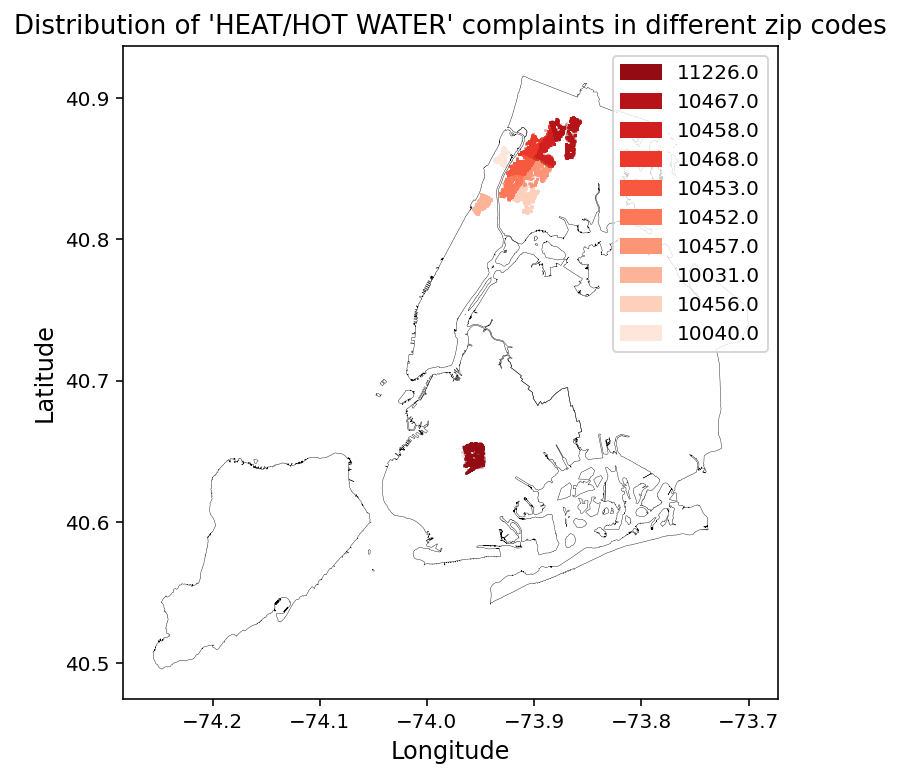

In [12]:
zip_codes = list(df_tc['Incident Zip'].value_counts().head(10).index)
colors = sns.color_palette('Reds_r', len(zip_codes)).as_hex()
patches = []

fig, ax = plt.subplots(figsize = (6, 6))

for index, value in enumerate(zip_codes):
    zip_df = df_tc[df_tc['Incident Zip'] == value]
    ax.scatter(zip_df['Longitude'], zip_df['Latitude'], c = colors[index], s = 1, alpha = 0.01, marker = '.')
    patches.append(mpatches.Patch(label = value, color = colors[index]))
    
borough_map['geometry'].boundary.plot(edgecolor = 'black', linewidth = 0.2, ax = ax)
    
plt.title("Distribution of 'HEAT/HOT WATER' complaints in different zip codes", size = 13)
plt.xlabel('Longitude', size = 12)
plt.ylabel('Latitude', size = 12)

plt.legend(patches, zip_codes);

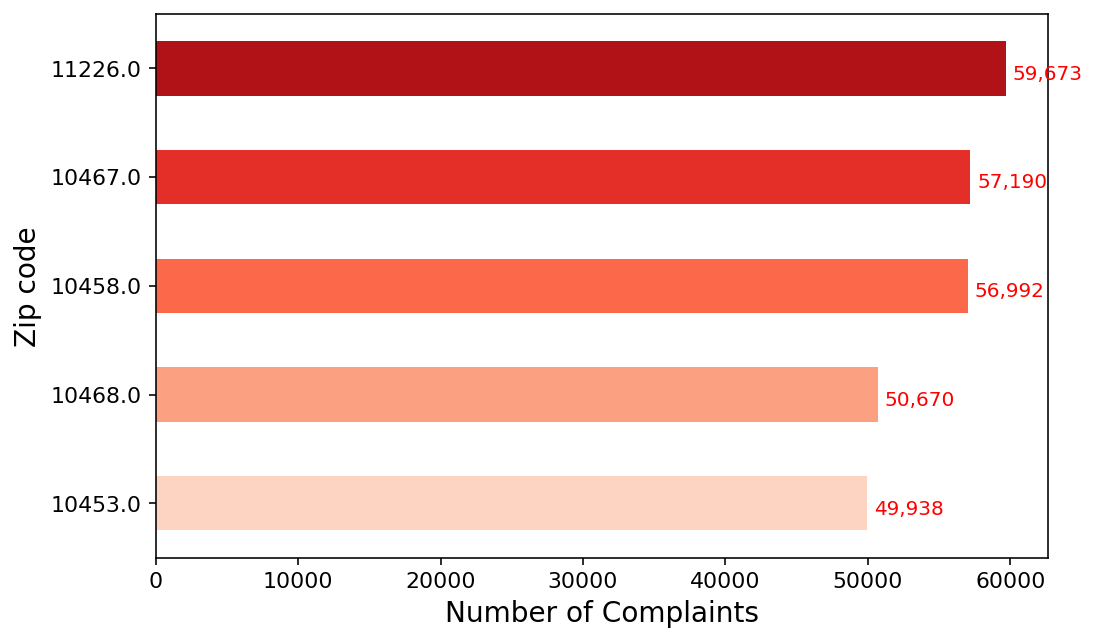

In [13]:
ny_zip = df_tc['Incident Zip'].value_counts().head(5).sort_values()
color = sns.color_palette('Reds', len(ny_zip))

ny_zip.plot(kind = 'barh', figsize = (8, 5), fontsize = 11, color = color)
plt.ylabel('Zip code', fontsize = 14)
plt.xlabel('Number of Complaints', fontsize = 14)

for index, value in enumerate(ny_zip):   
    label = str(format(int(value), ',')) 
    plt.annotate(label, xy = (value + 500, index - 0.1), color = 'red')

**11226** is the Zip Code with the highest number of submitted complaints (59,673). As we can see from the map but also the code below, it belongs to Brooklyn.

In [14]:
print('11226 Zip code belongs to: ', df[df['Incident Zip'] == 11226.0].head().iloc[0]['Borough'])

11226 Zip code belongs to:  BROOKLYN


## Streets

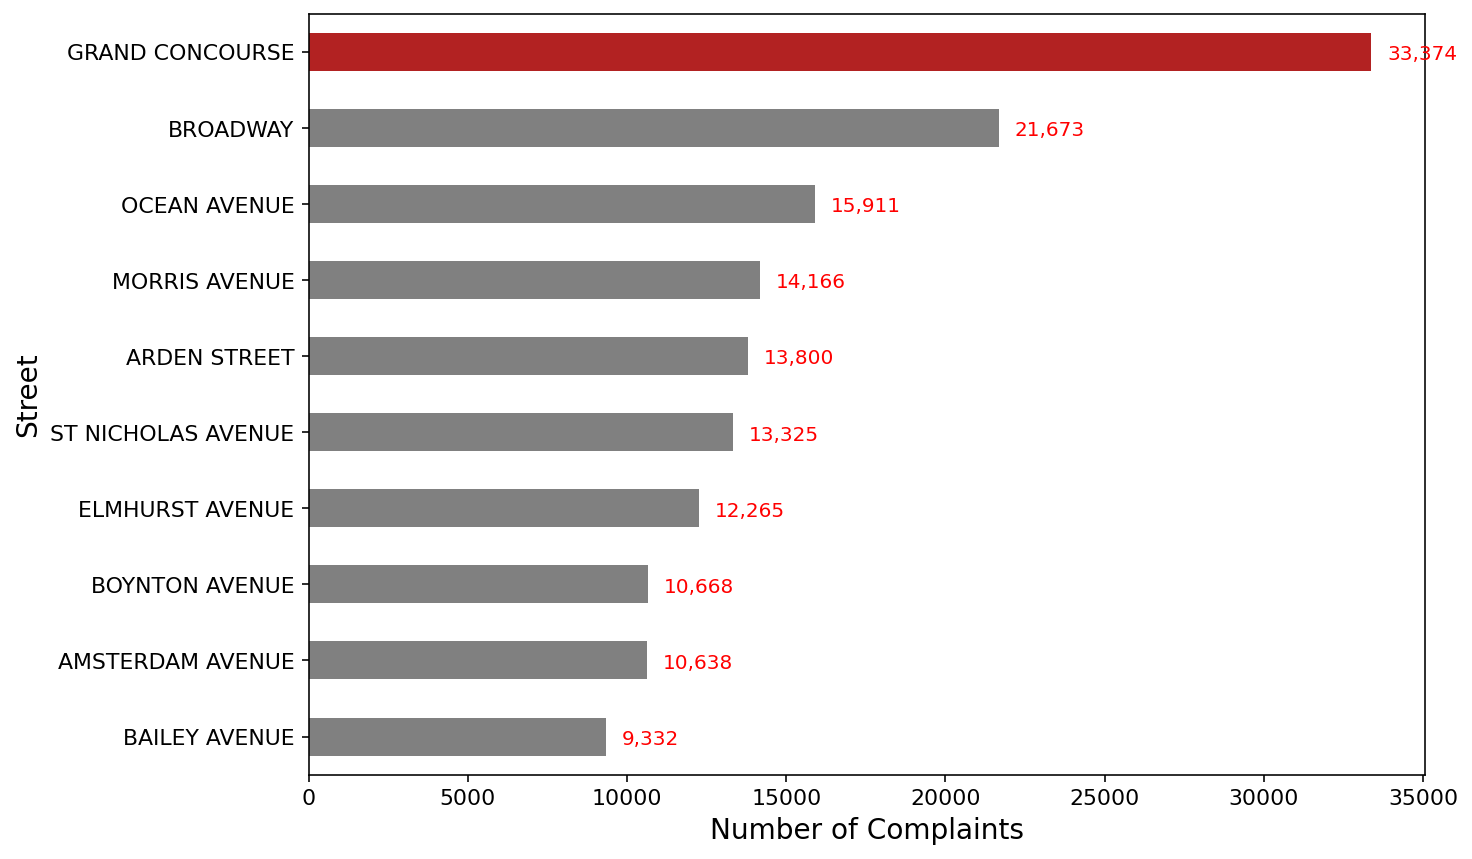

In [15]:
colors = ['Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'Grey', 'firebrick']
ny_streets = df_tc['Street Name'].value_counts().head(10).sort_values()

ny_streets.plot(kind = 'barh', figsize = (10, 7), fontsize = 11, color = colors)
plt.ylabel('Street', fontsize = 14)
plt.xlabel('Number of Complaints', fontsize = 14)

for index, value in enumerate(ny_streets):   
    label = str(format(int(value), ',')) 
    plt.annotate(label, xy = (value + 500, index - 0.1), color = 'red')

**Grand Concourse** is the street with the highest number of submitted complaints (33,374).

In [16]:
print('Grand Concourse\n\tBorough: ', df[df['Street Name'] == 'GRAND CONCOURSE'].iloc[0]['Borough'])
print('\tZip Code:', df[df['Street Name'] == 'GRAND CONCOURSE'].iloc[0]['Incident Zip'])

Grand Concourse
	Borough:  BRONX
	Zip Code: 10458.0


Grand Concourse belongs in the Bronx, the most affected borough of NY. It also belongs to the third most affected Zip code. 

<br>

# Conclusions

From the above analysis of the 'HEAT/HOT WATER' complaint, we can conclude that the Department of Housing Preservation and Development of New York City should focus on:

- **Bronx** and **Brooklyn**, since they are the first and second most affected boroughs in NYC, respectively,
- Houses in Brooklyn with **11226** as their Zip code, and
- **Grand Concourse**, a severely affected street in the Bronx.

<br>

---

# Quiz

## Question 1

For the complaint types that you selected in the previous module, which borough had the highest number of complaints submitted?

In [17]:
df_tc['Borough'].value_counts().idxmax()

'BRONX'

## Question 2

For the complaint types that you selected in the previous module, which borough had the lowest number of complaints submitted?

In [18]:
df_tc['Borough'].value_counts().idxmin()

'STATEN ISLAND'

## Question 3

For the complaint types that you selected in the previous module, which ZIP code had the highest number of complaints submitted?

In [19]:
df_tc['Incident Zip'].value_counts().idxmax()

11226.0

## Question 4

For the complaint types that you selected in the previous module, the address 89-21 Elmhurst Avenue had the highest number of complaints submitted?

In [20]:
df[df['Complaint Type']=='HEAT/HOT WATER']['Incident Address'].value_counts().head()

34 ARDEN STREET          13858
89-21 ELMHURST AVENUE    11548
3810 BAILEY AVENUE        7115
1025 BOYNTON AVENUE       5785
9511 SHORE ROAD           5006
Name: Incident Address, dtype: int64

34 ARDEN STREET is the address with the second-highest number of complaints submitted.

## Question 5

For the complaint types that you selected in the previous module, how many of the submitted tickets were closed?

In [21]:
df[df['Complaint Type']=='HEAT/HOT WATER']['Status'].value_counts()

Closed     2133331
Open         16091
Pending          2
Name: Status, dtype: int64